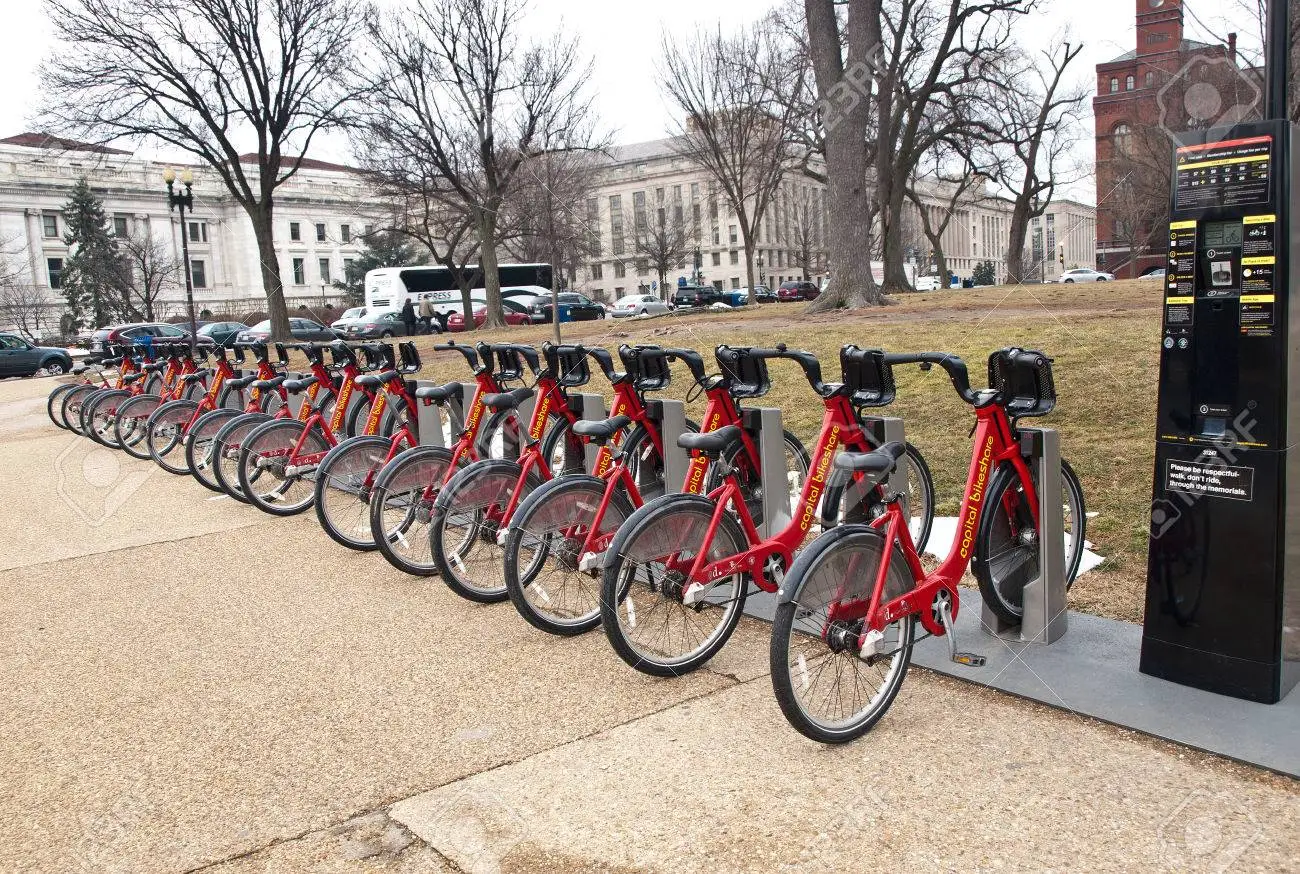

# Introduction
Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

# Data
[Hadi Fanaee-T](http://www.fanaee.com/) at the University of Porto compiled this data into a [CSV file](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. 

Here's what the first five rows look like:





In [1]:
import pandas as pd
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Attribute Information:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered



# Goal
In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

#### Exploring the dataset

Text(0.5, 1.0, 'Distribution of total rentals')

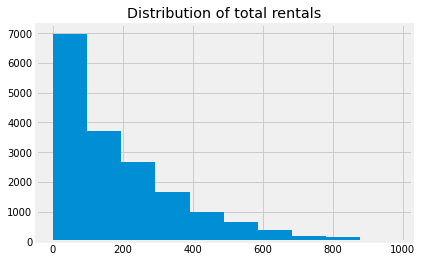

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline

plt.hist(bike_rentals["cnt"])
plt.title("Distribution of total rentals")

#### Correlation Matrix

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


<AxesSubplot:>

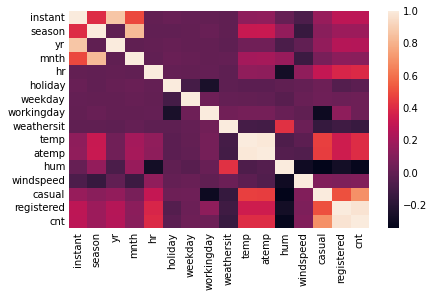

In [3]:
corr = bike_rentals.corr()["cnt"]
print(corr.sort_values())
sns.heatmap(bike_rentals.select_dtypes('number').corr())

####  Calculating Features
Let's create a new column with labels for morning, afternoon, evening, and night for the hr (hour) column.

In [4]:
def assign_label(hour):
    '''Assigns label to hour column
    Args:
        numeric: 0-24 hour
    Returns
        1 if the hour is from 6 to 12
        2 if the hour is from 12 to 18
        3 if the hour is from 18 to 24
        4 if the hour is from 0 to 6
    '''
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    else:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

#### Splitting the Data Into Train and Test Sets
We'll Select 80% of the rows in bike_rentals to be part of the training set and 20% for the test set. This allows us to train an algorithm using the training set, and evaluate its accuracy on the testing set.

In [5]:
train = bike_rentals.sample(frac=0.80, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

# Linear Regression
Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward.
#### Features Selection
Given many columns are highly correlated with **cnt**, we'll exclude features with *absolute of correlation* less than 0.30. 
We'll also need to ignore the **casual** and **registered** columns because **cnt** is derived from them.

In [6]:
low_corr_cols = list(corr[abs(corr) < 0.30].index)
excluded_cols =  ['cnt', 'casual', 'registered', 'dteday']
features = [col for col in bike_rentals.columns if col not in excluded_cols + low_corr_cols]
print(features)

['hr', 'temp', 'atemp', 'hum', 'time_label']


#### Model Fitting & Prediction

In [7]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(train[features], train['cnt'])
predictions = ols.predict(test[features])

#### Root Mean Square Error
RMSE tells us how concentrated the data is around the best fit line.

In [8]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['cnt'], predictions) ** (1/2)

137.04413338501794

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with RMSE, which leads to a higher total error.

#### $R^2$ Goodness of Fit 


In [9]:
ols.score(train[features], train['cnt'])

0.4027051447854786

R-squared of the model is a bit low. This tells us that only 40% of the proportion of the variance in the target variable that can be explained by the features/predictors.

Both RMSE and R-squared tests show that linear regression is not a great model for this dataset. Next, we'll apply a different model called Decision Tree.

# Decision Tree
Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [10]:
excluded_cols =  ['cnt', 'casual', 'registered', 'dteday']
features = [col for col in bike_rentals.columns if col not in excluded_cols]
print(features)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


In [11]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state = 1)
tree.fit(train[features], train['cnt'])

DecisionTreeRegressor(random_state=1)

#### Area Under the Curve
AUC ranges from 0 to 1 and is a measure of how accurate our predictions
are, which makes it ideal for binary classification. The higher the AUC, the more accurate our predictions. Following Samuele Mazzanti's [blog post](https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb), we can calculate the AUC for continuous target variable.

In [12]:
from regression_roc_auc_score import regression_roc_auc_score

train_auc_score = regression_roc_auc_score(train['cnt'], tree.predict(train[features]))
test_auc_score = regression_roc_auc_score(test['cnt'], tree.predict(test[features]))
print(train_auc_score)
print(test_auc_score)

1.0
0.9197


#### Overfitting Problem
Based on our AUC measurements, it appears that we are in fact overfitting.
Let's try improving our model by tweaking the minimum number of samples per leaf.

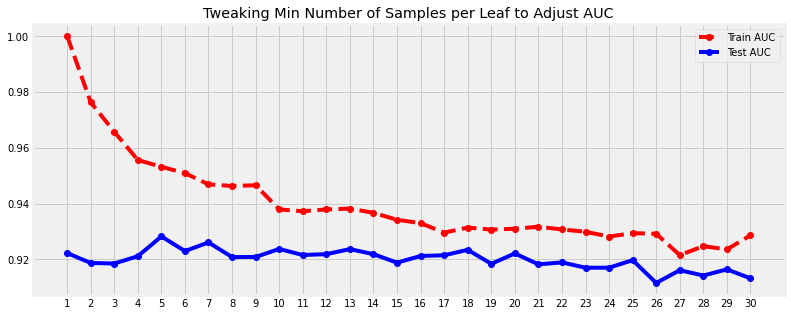

[1.0, 0.97625, 0.9657, 0.9556, 0.95315, 0.9509, 0.94685, 0.9463, 0.94655, 0.9379, 0.93725, 0.9379, 0.9382, 0.9367, 0.9342, 0.933, 0.9296, 0.9314, 0.9307, 0.931, 0.9317, 0.93075, 0.9299, 0.9282, 0.9294, 0.9292, 0.92155, 0.92475, 0.9236, 0.9286]
[0.9223, 0.91875, 0.91855, 0.92115, 0.92825, 0.923, 0.9261, 0.92085, 0.9209, 0.92375, 0.9216, 0.9219, 0.9237, 0.9219, 0.91885, 0.92125, 0.9215, 0.92345, 0.91845, 0.92215, 0.91825, 0.91895, 0.91705, 0.91705, 0.91975, 0.9116, 0.91615, 0.91425, 0.91645, 0.91325]


In [13]:
import numpy as np

train_aucs = []
test_aucs  = []
samples_leaves = np.arange(1, 31)

for i in samples_leaves:
    tree = DecisionTreeRegressor(random_state = 1, min_samples_leaf = i)
    tree.fit(train[features], train['cnt'])
    train_aucs.append(regression_roc_auc_score(train['cnt'], tree.predict(train[features])))
    test_aucs.append(regression_roc_auc_score(test['cnt'], tree.predict(test[features])))
    
plt.figure(figsize=(12, 5))
plt.plot(samples_leaves, train_aucs, c='r', linestyle='--', marker='o')
plt.plot(samples_leaves, test_aucs, c='b', marker='o')
plt.xticks(samples_leaves)
plt.legend(['Train AUC', 'Test AUC'])
plt.title('Tweaking Min Number of Samples per Leaf to Adjust AUC')
plt.show()

print(train_aucs)
print(test_aucs)

We just improved our AUC. It seems from the graph that our optimal number of samples per leaf is 18. Let's try restricting the maximum depth of tree if we could further improve our AUC.

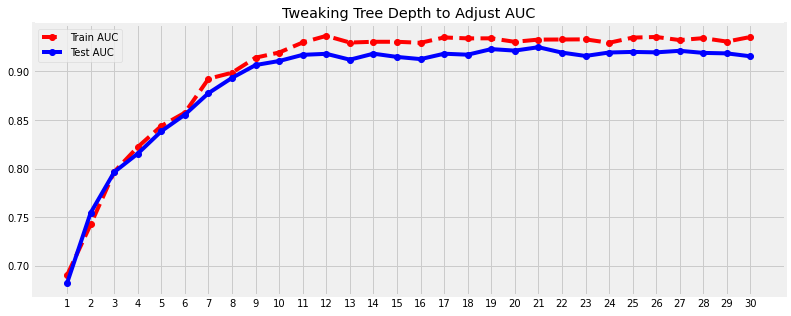

[0.69025, 0.74245, 0.7967, 0.82225, 0.84395, 0.8576, 0.8925, 0.89875, 0.91425, 0.91955, 0.9299, 0.9367, 0.9298, 0.9306, 0.9306, 0.92955, 0.93505, 0.9341, 0.93415, 0.93055, 0.93285, 0.93295, 0.9331, 0.92955, 0.9349, 0.93555, 0.93235, 0.93435, 0.9308, 0.93555]
[0.6822, 0.7545, 0.7964, 0.81545, 0.8385, 0.8556, 0.8777, 0.89345, 0.90665, 0.9108, 0.91715, 0.9182, 0.91215, 0.91835, 0.915, 0.91275, 0.9183, 0.9173, 0.92305, 0.9215, 0.925, 0.91945, 0.916, 0.91955, 0.92015, 0.9197, 0.9213, 0.91915, 0.91865, 0.91565]


In [15]:
train_aucs = []
test_aucs  = []
max_depths = np.arange(1, 31)

for i in max_depths:
    tree = DecisionTreeRegressor(random_state = 1, min_samples_leaf = 18, max_depth = i)
    tree.fit(train[features], train['cnt'])
    train_aucs.append(regression_roc_auc_score(train['cnt'], tree.predict(train[features])))
    test_aucs.append(regression_roc_auc_score(test['cnt'], tree.predict(test[features])))

plt.figure(figsize=(12, 5))
plt.plot(samples_leaves, train_aucs, c='r', linestyle='--', marker='o')
plt.plot(samples_leaves, test_aucs, c='b', marker='o')
plt.xticks(samples_leaves)
plt.legend(['Train AUC', 'Test AUC'])
plt.title('Tweaking Tree Depth to Adjust AUC')
plt.show()

print(train_aucs)
print(test_aucs)

At maximum depth of 2, we aren't overfitting anymore because both AUC values are about the same. However, we sacrificed a significant portion of our accuracy in doing so. 

### Decision Tree Errors

In [35]:
# default setting
tree = DecisionTreeRegressor()
tree.fit(train[features], train["cnt"])
predictions = tree.predict(test[features])
print(mean_squared_error(test['cnt'], predictions) ** (1/2))

# min_samples_leaf = 18
tree = DecisionTreeRegressor(min_samples_leaf = 18)
tree.fit(train[features], train["cnt"])
predictions = tree.predict(test[features])
print(mean_squared_error(test['cnt'], predictions) ** (1/2))

# min_samples_leaf = 18 & max_depth = 21
tree = DecisionTreeRegressor(min_samples_leaf = 18, max_depth = 2)
tree.fit(train[features], train["cnt"])
predictions = tree.predict(test[features])
print(mean_squared_error(test['cnt'], predictions) ** (1/2))

56.69890241528326
55.41275504992715
136.15169181899654


#### Summary:
| Settings | Train AUC | Test AUC | RMSE |
| --- | --- | --- | --- | 
| Default | 1.0 | 0.920 | 56.699 |
| min_samples_leaf = 18 | 0.931 | 0.923 | 55.413 |
| min_samples_leaf = 18 & max_depth = 2 | 0.742 | 0.755 | 136.152 |

Compared to our linear regression's RMSE of 137, all of our decision trees' lower RMSE indicates a better fit model. Let's see if we could perform better with random forests.

## Random Forests
A random forest combine the predictions of multiple decision trees to create a more accurate final prediction. Random forests tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [40]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=10, random_state=1, min_samples_leaf=18)
clf.fit(train[features], train["cnt"])

predictions = clf.predict(train[features])
print(regression_roc_auc_score(train["cnt"], predictions))

predictions = clf.predict(test[features])
print(regression_roc_auc_score(test["cnt"], predictions))

rmse = mean_squared_error(test['cnt'], predictions) ** (1/2)
print(f"RMSE:{rmse}")

0.929
0.9155
RMSE:54.2592254148194


#### Tweaking Parameters to Increase Accuracy
The easiest tweak is to increase the number of estimators we use. This approach yields diminishing returns -- going from 10 trees to 100 will make a bigger difference than going from 100 to 500, which will make a bigger difference than going from 500 to 1000.

In [41]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=18)
clf.fit(train[features], train["cnt"])

predictions = clf.predict(train[features])
print(regression_roc_auc_score(train["cnt"], predictions))

predictions = clf.predict(test[features])
print(regression_roc_auc_score(test["cnt"], predictions))

rmse = mean_squared_error(test['cnt'], predictions) ** (1/2)
print(f"RMSE:{rmse}")

0.932
0.9238
RMSE:52.12846047093165


Increasing our number of estimators increased our model accuracy by 1% and reduces our initial RMSE of 54.259 down to 52.128. 
***
# Conclusion
In this project, we predicted the total number of bikes people rented in a given hour with three different machine learning models. We mainly used root mean squared error (RMSE) and area under the curve (AUC) as a criterion for models in predicting the total count of bike rentals. We concluded that linear regression was the worst performing model, while random forests performed slightly better than decision trees.